In [4]:
import os


from imutils import paths
from tensorflow import keras
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import imageio
import cv2
from glob import glob
from IPython.display import Image

In [5]:
IMG_SIZE = 224
BATCH_SIZE = 64
EPOCHS = 10

MAX_SEQ_LENGTH = 20
NUM_FEATURES = 2048

In [6]:
non=glob("D:/Sun'iyX/Data/Sliced/TV_Content/*")
vio=glob("D:/Sun'iyX/Data/Sliced/Add/*")
label=[0]*len(non)+[1]*len(vio)

main_df=pd.DataFrame(zip(non+vio,label),columns=['video_name','tag'])

train_df, test_df = train_test_split(main_df, test_size=0.2, random_state=42, stratify=main_df['tag'])

# If you want to reset the index
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [7]:
print(f"Total videos for training: {len(train_df)}")
print(f"Total videos for testing: {len(test_df)}")

train_df.sample(10)

Total videos for training: 881
Total videos for testing: 221


,video_name,tag
395,D:/Sun'iyX/Data/Sliced/TV_Content\1224(6)_cut_...,0
238,D:/Sun'iyX/Data/Sliced/Add\1224(10)_cut_135_14...,1
39,D:/Sun'iyX/Data/Sliced/Add\1224(1)_cut_15_20.mp4,1
765,D:/Sun'iyX/Data/Sliced/TV_Content\1224(5)_cut_...,0
154,D:/Sun'iyX/Data/Sliced/TV_Content\1224(4)_cut_...,0
256,D:/Sun'iyX/Data/Sliced/TV_Content\1224(7)_cut_...,0
59,D:/Sun'iyX/Data/Sliced/TV_Content\1224(2)_cut_...,0
352,D:/Sun'iyX/Data/Sliced/Add\1224(1)_cut_135_140...,1
758,D:/Sun'iyX/Data/Sliced/TV_Content\1224(6)_cut_...,0
729,D:/Sun'iyX/Data/Sliced/TV_Content\1224(7)_cut_...,0


In [8]:
def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]


def load_video(path, max_frames=0, resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)

In [9]:
def build_feature_extractor():
    feature_extractor = keras.applications.InceptionV3(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.inception_v3.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")


feature_extractor = build_feature_extractor()

In [10]:
def prepare_all_videos(df, root_dir):
    num_samples = len(df)
    video_paths = df["video_name"].values.tolist()
    labels = df["tag"].values

    # `frame_masks` and `frame_features` are what we will feed to our sequence model.
    # `frame_masks` will contain a bunch of booleans denoting if a timestep is
    # masked with padding or not.
    frame_masks = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype="bool")
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )

    # For each video.
    for idx, path in enumerate(video_paths):
        # Gather all its frames and add a batch dimension.
        frames = load_video(os.path.join(root_dir, path))
        frames = frames[None, ...]

        # Initialize placeholders to store the masks and features of the current video.
        temp_frame_mask = np.zeros(
            shape=(
                1,
                MAX_SEQ_LENGTH,
            ),
            dtype="bool",
        )
        temp_frame_features = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        # Extract features from the frames of the current video.
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                temp_frame_features[i, j, :] = feature_extractor.predict(
                    batch[None, j, :], verbose=0,
                )
            temp_frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

        frame_features[idx,] = temp_frame_features.squeeze()
        frame_masks[idx,] = temp_frame_mask.squeeze()

    return (frame_features, frame_masks), labels


train_data, train_labels = prepare_all_videos(train_df, "train")
test_data, test_labels = prepare_all_videos(test_df, "test")

print(f"Frame features in train set: {train_data[0].shape}")
print(f"Frame masks in train set: {train_data[1].shape}")

Frame features in train set: (881, 20, 2048)
Frame masks in train set: (881, 20)


In [11]:
# Utility for our sequence model.
def get_sequence_model():
    class_vocab = [0,1]

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    # Refer to the following tutorial to understand the significance of using `mask`:
    # https://keras.io/api/layers/recurrent_layers/gru/
    x = keras.layers.GRU(16, return_sequences=True)(
        frame_features_input, mask=mask_input
    )
    x = keras.layers.GRU(8)(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(8, activation="relu")(x)
    output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output)

    rnn_model.compile(
        loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    return rnn_model


# Utility for running experiments.
def run_experiment():
    filepath = "D:/Sun'iyX/Data/ckpt.weights.h5"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1        
    )

    seq_model = get_sequence_model()
    history = seq_model.fit(
        [train_data[0], train_data[1]],
        train_labels,
        validation_split=0.3,
        epochs=EPOCHS,
        callbacks=[checkpoint],
    )

    seq_model.load_weights(filepath)
    _, accuracy = seq_model.evaluate([test_data[0], test_data[1]], test_labels)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history, seq_model


_, sequence_model = run_experiment()

Epoch 1/10
20/20 [==============================] - ETA: 0s - loss: 0.6857 - accuracy: 0.5763
Epoch 1: val_loss improved from inf to 0.65025, saving model to D:/Sun'iyX/Data\ckpt.weights.h5
20/20 [==============================] - 20s 584ms/step - loss: 0.6857 - accuracy: 0.5763 - val_loss: 0.6503 - val_accuracy: 0.6377
Epoch 2/10
20/20 [==============================] - ETA: 0s - loss: 0.6383 - accuracy: 0.6542
Epoch 2: val_loss improved from 0.65025 to 0.61723, saving model to D:/Sun'iyX/Data\ckpt.weights.h5
20/20 [==============================] - 8s 413ms/step - loss: 0.6383 - accuracy: 0.6542 - val_loss: 0.6172 - val_accuracy: 0.6415
Epoch 3/10
20/20 [==============================] - ETA: 0s - loss: 0.6376 - accuracy: 0.6607
Epoch 3: val_loss improved from 0.61723 to 0.58021, saving model to D:/Sun'iyX/Data\ckpt.weights.h5
20/20 [==============================] - 8s 401ms/step - loss: 0.6376 - accuracy: 0.6607 - val_loss: 0.5802 - val_accuracy: 0.7774
Epoch 4/10
20/20 [==========

Test video path: D:/Sun'iyX/Data/Sliced/TV_Content\1224(2)_cut_190_195.mp4
1/1 [==============================] - 0s 35ms/step
  Class0: 92.33%
  Class1:  7.67%


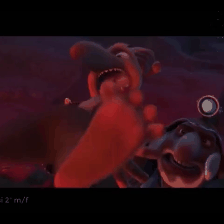

In [15]:
def prepare_single_video(frames):
    frames = frames[None, ...]
    frame_mask = np.zeros(
        shape=(
            1,
            MAX_SEQ_LENGTH,
        ),
        dtype="bool",
    )
    frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    for i, batch in enumerate(frames):
        video_length = batch.shape[0]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :])
        frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

    return frame_features, frame_mask


def sequence_prediction(path):
    class_vocab = {0: "Class0", 1: "Class1"}

    frames = load_video(os.path.join("test", path))
    frame_features, frame_mask = prepare_single_video(frames)
    probabilities = sequence_model.predict([frame_features, frame_mask])[0]

    for i in np.argsort(probabilities)[::-1]:
        print(f"  {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")
        
    return frames


# This utility is for visualization.
# Referenced from:
# https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub
def to_gif(images):
    converted_images = images.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images, duration=100)
    return Image("animation.gif")


test_video = np.random.choice(test_df["video_name"].values.tolist())
print(f"Test video path: {test_video}")
test_frames = sequence_prediction(test_video)
to_gif(test_frames[:MAX_SEQ_LENGTH])